   # Комплексний курс з алгоритмів та структур даних на графах







   ## Розділ 1: Класичні алгоритми на графах







   ### 🎯 Цілі розділу:



   1. **Опанувати** фундаментальні алгоритми для пошуку шляхів, обходу та аналізу структури графів.



   2. **Навчитись** застосовувати ці алгоритми для вирішення практичних задач з різних доменів.



   3. **Розуміти** компроміси (швидкість, пам'ять, обмеження) між різними підходами.

In [22]:
# =============================================================================
# Клітинка 1: Налаштування середовища та імпорти
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import time

# Імпортуємо наші власні модулі
from src.algorithms.shortest_path import Dijkstra, AStar, BellmanFord, FloydWarshall, BidirectionalSearch
from src.algorithms.traversal import BFS, DFS, find_negative_cycle_bf
from src.algorithms.mst import Kruskal, Prim
from src.utils.graph_generator import GraphGenerator
from src.utils.visualizer import PathVisualizer, TraversalVisualizer, MstVisualizer, AnalysisVisualizer

# Налаштування візуалізації
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
print("✅ Середовище готове до роботи.")



✅ Середовище готове до роботи.


   ## 1.1 Алгоритми пошуку найкоротшого шляху







   Пошук найкоротшого шляху — одна з найбільш фундаментальних задач в теорії графів з величезною кількістю практичних застосувань, від GPS-навігації до маршрутизації інтернет-трафіку. У цьому розділі ми розглянемо ключові алгоритми та їхні особливості.

   ### Алгоритм Дейкстри (Dijkstra's Algorithm)







   **Ідея:** "Жадібний" алгоритм, який знаходить найкоротший шлях від однієї стартової вершини до всіх інших у графі з **невід'ємними** вагами ребер. На кожному кроці він обирає найближчу ще не відвідану вершину і оновлює відстані до її сусідів.







   | Складність | Використання пам'яті | Обмеження |
   | :--- | :--- | :--- |
   | `O(E log V)` | `O(V)` | Не працює з від'ємними вагами |







   **Домени застосування:**



   - **Логістика:** Розрахунок оптимальних маршрутів доставки.



   - **Мережі:** Маршрутизація пакетів за протоколом OSPF.



   - **Біоінформатика:** Аналіз метаболічних шляхів.

Концептуальний приклад: пошук шляху з 'A' до 'E'
  -> Знайдений шлях: A → C → B → D → E
  -> Загальна відстань: 10.00


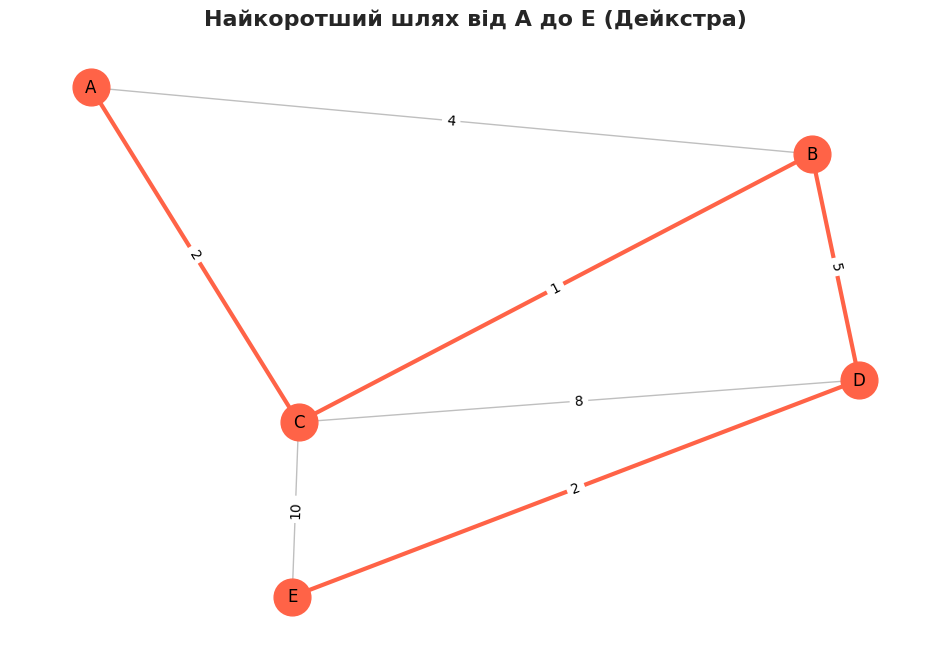

In [12]:
# =============================================================================
# Клітинка 2: Концептуальний приклад
# =============================================================================
conceptual_graph = nx.Graph()
edges = [('A', 'B', 4), ('A', 'C', 2), ('B', 'C', 1), ('B', 'D', 5), ('C', 'D', 8), ('C', 'E', 10), ('D', 'E', 2)]
conceptual_graph.add_weighted_edges_from(edges)
start_node, end_node = 'A', 'E'

path_info = Dijkstra.find_path(conceptual_graph, start_node, end_node)

print(f"Концептуальний приклад: пошук шляху з '{start_node}' до '{end_node}'")
print(f"  -> Знайдений шлях: {' → '.join(path_info['path'])}")
print(f"  -> Загальна відстань: {path_info['distance']:.2f}")

fig = PathVisualizer.draw_path(
    conceptual_graph,
    path=path_info['path'],
    title=f"Найкоротший шлях від {start_node} до {end_node} (Дейкстра)"
)
plt.show()



   #### Практичний приклад: Оптимізація логістики



   **Задача:** У нас є мережа складів та магазинів. Потрібно знайти найдешевший маршрут доставки товару з головного складу (хабу) до віддаленого магазину. Вага ребер — це вартість перевезення між пунктами.

Практичний приклад: маршрут з Хабу-0 до Магазину-42
  -> Оптимальний маршрут: 0 → 2 → 10 → 42
  -> Вартість доставки: $471.04


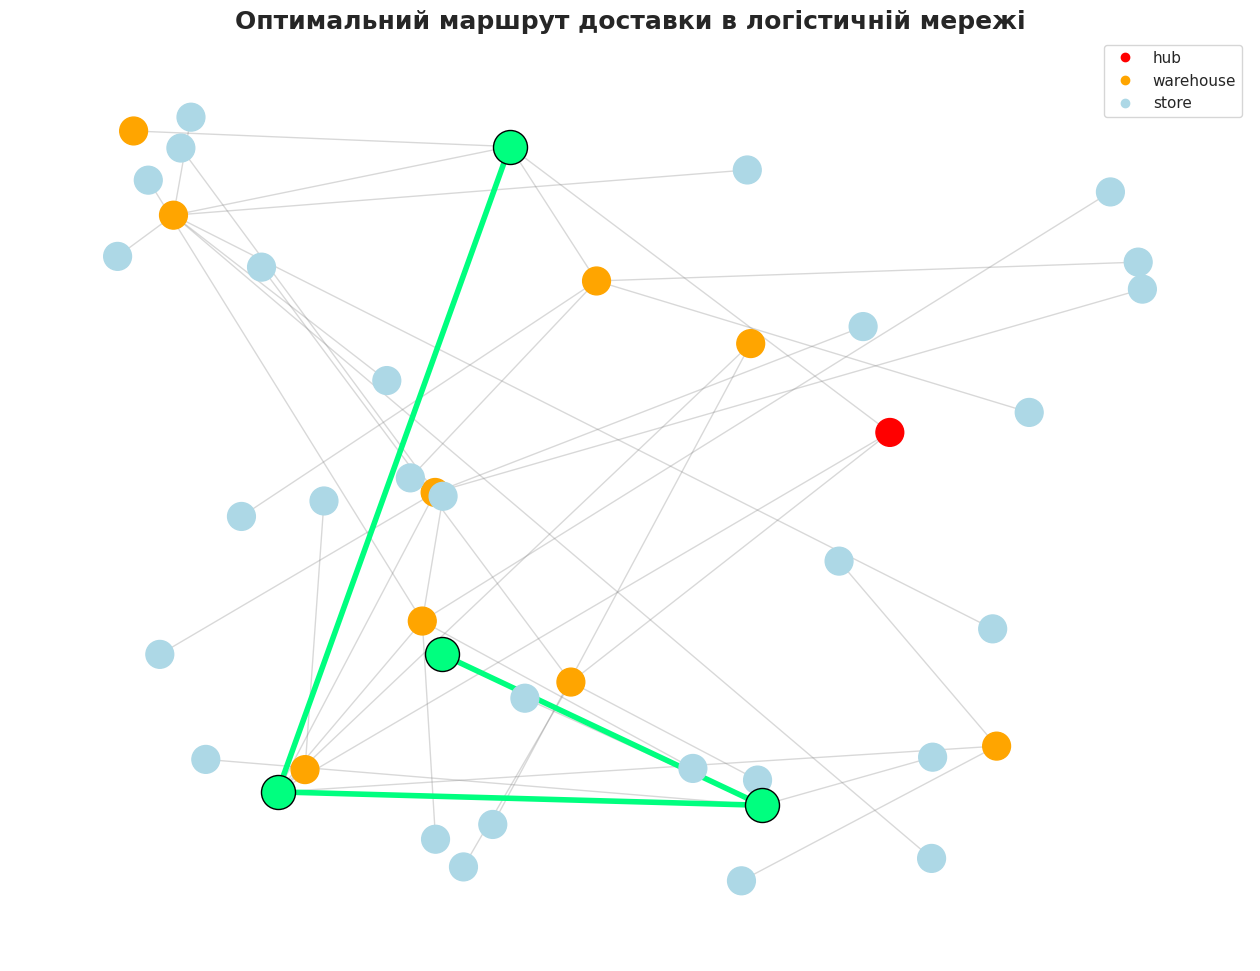

In [13]:
# =============================================================================
# Клітинка 3: Практичний приклад з домену "Логістика"
# =============================================================================
logistics_graph, node_types, pos = GraphGenerator.create_logistics_network(n_hubs=3, n_warehouses=10, n_stores=30, seed=42)
hub_node = 0
store_node = list(node_types.keys())[-1]

logistics_path_info = Dijkstra.find_path(logistics_graph, hub_node, store_node)

print(f"Практичний приклад: маршрут з Хабу-{hub_node} до Магазину-{store_node}")
print(f"  -> Оптимальний маршрут: {' → '.join(map(str, logistics_path_info['path']))}")
print(f"  -> Вартість доставки: ${logistics_path_info['distance']:.2f}")

fig = PathVisualizer.draw_logistics_network(
    logistics_graph, node_types, pos,
    path=logistics_path_info['path'],
    title="Оптимальний маршрут доставки в логістичній мережі"
)
plt.savefig('./data/dijkstra_logistics_path.png', dpi=300, bbox_inches='tight')
plt.show()



   ### Алгоритм A*







   **Ідея:** Покращена версія Дейкстри, яка використовує **евристичну функцію** `h(n)` для оцінки відстані від поточної вершини `n` до цілі. Це дозволяє A* рухатися більш цілеспрямовано, замість того, щоб досліджувати граф у всіх напрямках. Пріоритет вершини визначається як `f(n) = g(n) + h(n)`, де `g(n)` — вже пройдений шлях.







   **Ключова вимога:** Евристика має бути *допустимою* (admissible), тобто ніколи не переоцінювати реальну вартість шляху до цілі.

Порівняння продуктивності Dijkstra та A*:
           distance  execution_time  visited_nodes
algorithm                                         
Dijkstra   2.957119        0.211261              7
A*         2.957119        0.181250              3


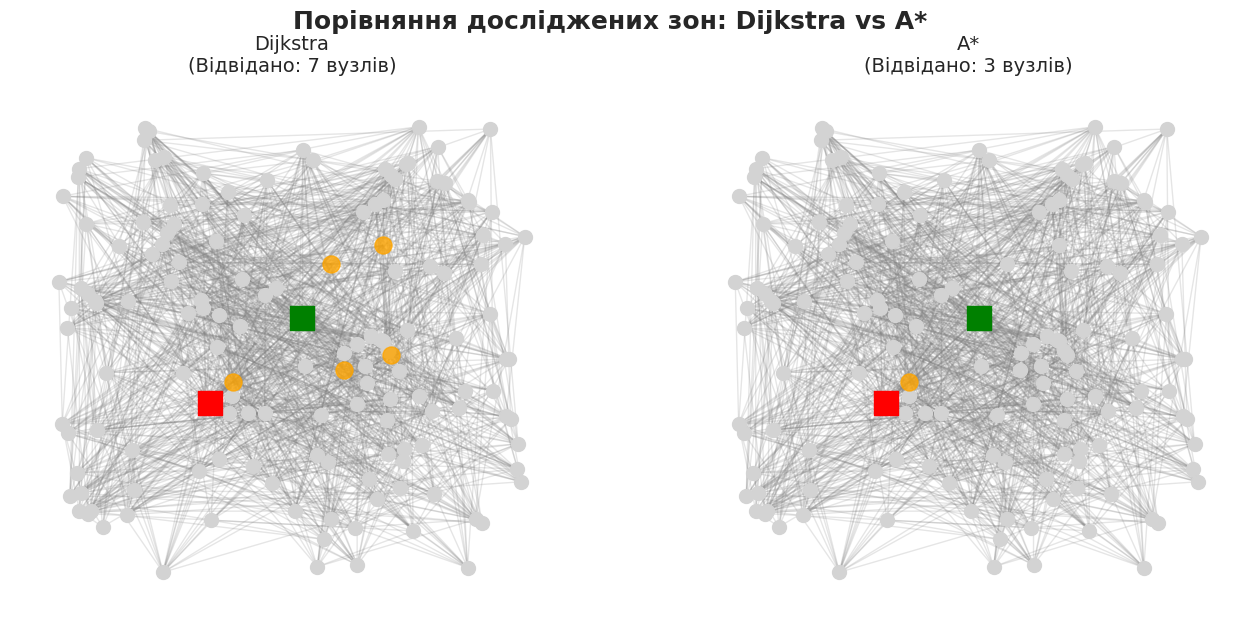

In [14]:
# =============================================================================
# Клітинка 4: Порівняльний аналіз Dijkstra vs A*
# =============================================================================
city_graph, pos = GraphGenerator.create_city_road_network(n_intersections=150, seed=101)
start_city, end_city = 0, 149

# Запускаємо обидва алгоритми
result_dijkstra = Dijkstra.find_path(city_graph, start_city, end_city)
result_astar = AStar.find_path(city_graph, start_city, end_city, positions=pos, heuristic='euclidean')

# Відображаємо результати у вигляді таблиці
comparison_df = pd.DataFrame([result_dijkstra, result_astar]).set_index('algorithm')
print("Порівняння продуктивності Dijkstra та A*:")
print(comparison_df[['distance', 'execution_time']].assign(visited_nodes=lambda df: [len(result_dijkstra['visited_nodes']), len(result_astar['visited_nodes'])]))

# Візуалізуємо відвідані вузли
fig = PathVisualizer.draw_visited_nodes_comparison(
    city_graph, pos,
    results=[result_dijkstra, result_astar],
    title="Порівняння досліджених зон: Dijkstra vs A*"
)
plt.savefig('./data/dijkstra_vs_astar_visited.png', dpi=300, bbox_inches='tight')
plt.show()



   #### Висновки з порівняння



   На візуалізації чітко видно, що **Dijkstra** (зліва) досліджує велике коло навколо стартової точки, тоді як **A*** (справа) рухається вузьким "коридором" у напрямку цілі. Це призводить до значного зменшення кількості відвіданих вузлів та, як наслідок, до прискорення роботи, що критично важливо для великих карт.

   ### Алгоритм Беллмана-Форда (Bellman-Ford)







   **Ідея:** На відміну від Дейкстри, цей алгоритм може працювати з графами, що містять ребра з **від'ємною вагою**. Він працює шляхом ітеративного оновлення (релаксації) відстаней до всіх вершин `V-1` разів. На `V`-й ітерації він може виявити наявність циклу з від'ємною сумарною вагою.







   **Домени застосування:**



   - **Фінанси:** Пошук арбітражних можливостей на валютних ринках (де від'ємний цикл означає безпрограшну послідовність обмінів).



   - **Мережі:** Маршрутизація в мережах, де можуть бути "штрафи" (від'ємні ваги).

In [15]:


# =============================================================================
# Клітинка 5: Практичний приклад Bellman-Ford - Пошук арбітражу
# =============================================================================
currencies = ['USD', 'EUR', 'GBP', 'JPY']
rates = [
    ('USD', 'EUR', 0.92), ('EUR', 'USD', 1.08),
    ('USD', 'GBP', 0.79), ('GBP', 'USD', 1.26),
    ('EUR', 'GBP', 0.85), ('GBP', 'EUR', 1.17),
    ('JPY', 'USD', 0.0067), ('USD', 'JPY', 149.0),
    # створюємо арбітраж
    ('EUR', 'JPY', 163.0), ('JPY', 'GBP', 0.0055), ('GBP', 'EUR', 1.18)  # EUR→JPY→GBP→EUR
]

arbitrage_graph = nx.DiGraph()
for u, v, rate in rates:
    arbitrage_graph.add_edge(u, v, weight=-np.log(rate))

cycle_nodes = find_negative_cycle_bf(arbitrage_graph, weight="weight")

if cycle_nodes:
    print("📈 Знайдено арбітражний цикл:", " → ".join(cycle_nodes))
    # (опційно) перевіримо, що сума ваг < 0
    total_weight = sum(arbitrage_graph[u][v]["weight"] for u, v in zip(cycle_nodes, cycle_nodes[1:]))
    print(f"Σ weights = {total_weight:.6f}  (< 0 ⇒ profit)")
else:
    print("❌ Від'ємних циклів не знайдено.")



📈 Знайдено арбітражний цикл: USD → JPY → GBP → USD
Σ weights = -0.032051  (< 0 ⇒ profit)


   ## 1.2 Алгоритми обходу графів







   Обхід графу — це процес систематичного відвідування кожної вершини. Це фундаментальна операція, що лежить в основі багатьох складніших алгоритмів.

   ### Пошук в ширину (BFS - Breadth-First Search)







   **Ідея:** BFS досліджує граф "рівнями", гарантуючи знаходження найкоротшого шляху в термінах кількості ребер.







   **Практичне застосування:**



   - **Соціальні мережі:** пошук "друзів друзів" (2-й рівень зв'язків).



   - **Веб-краулери:** індексація сторінок, починаючи з головної.

Рівні зв'язків для користувача 'User_0':
 Level  User ID    Name
     0        0  User_0
     1        1  User_1
     1       19 User_19
     1        2  User_2
     1        9  User_9
     2        3  User_3
     2        8  User_8
     2       14 User_14
     2       18 User_18
     2       17 User_17
     2       13 User_13
     2        4  User_4
     2        7  User_7
     2       11 User_11
     2        5  User_5
     3       12 User_12
     3        6  User_6
     3       10 User_10
     3       16 User_16
     3       15 User_15


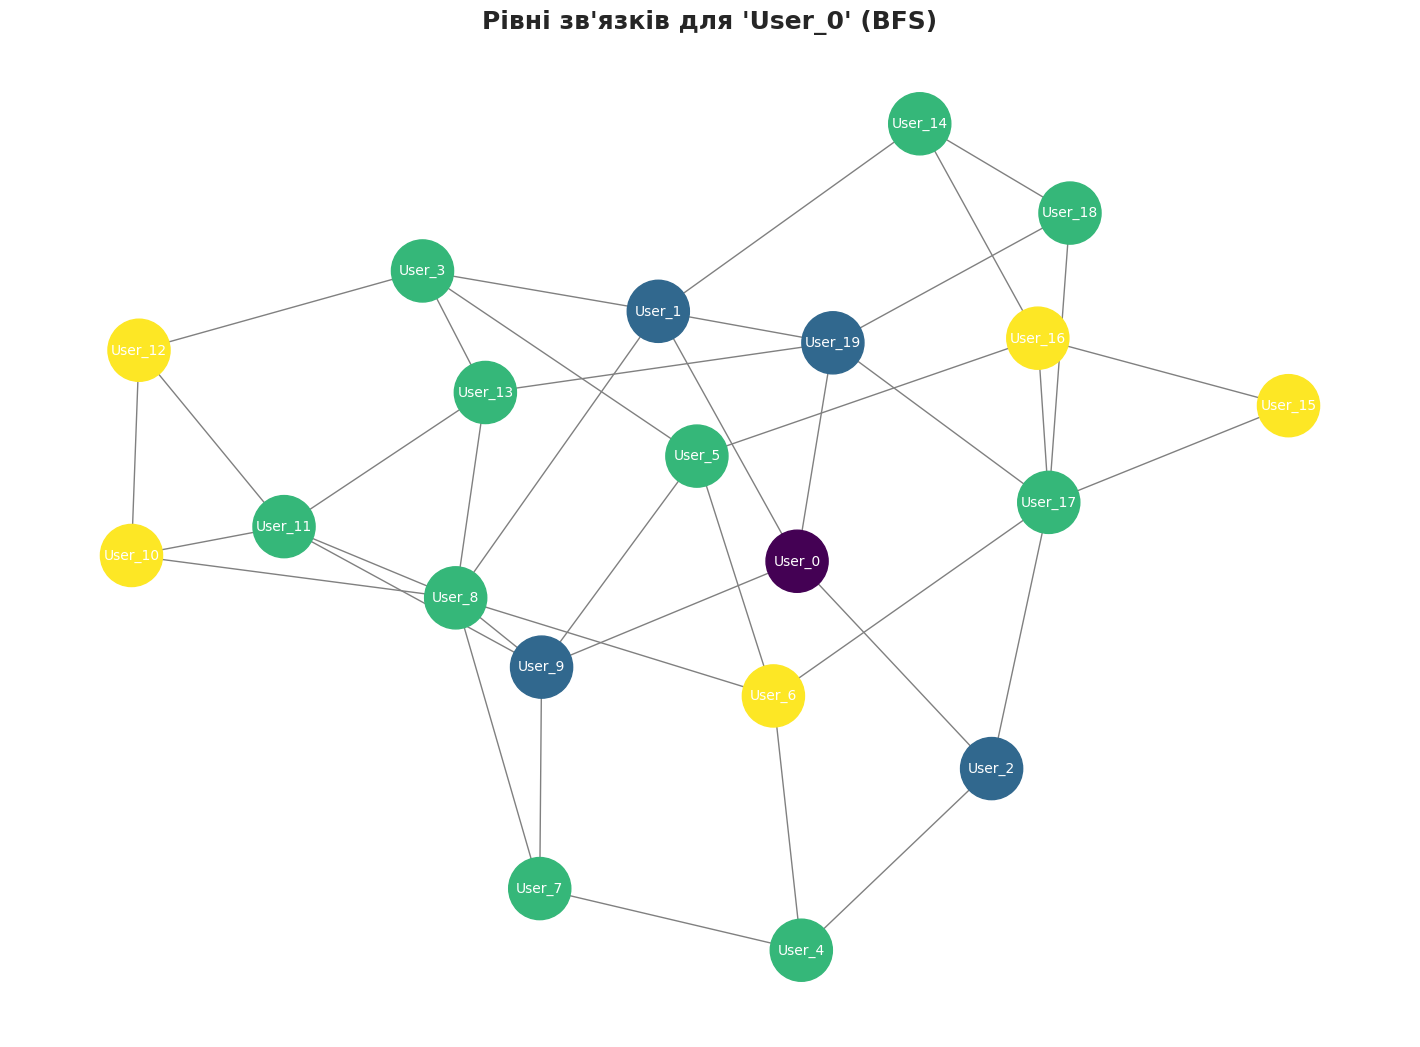

In [16]:
# =============================================================================
# Клітинка 6: Практичний приклад BFS - Аналіз соціальної мережі
# =============================================================================
social_graph, names = GraphGenerator.create_social_network(seed=42)
start_user_id = 0
start_user_name = names[start_user_id]

bfs_traversal = BFS(social_graph)
result = bfs_traversal.traverse(start_node=start_user_id)

levels_df = pd.DataFrame(result['distances'].items(), columns=['User ID', 'Level']).sort_values(by='Level')
levels_df['Name'] = levels_df['User ID'].map(names)
print(f"Рівні зв'язків для користувача '{start_user_name}':")
print(levels_df[['Level', 'User ID', 'Name']].to_string(index=False))

fig = TraversalVisualizer.draw_bfs_levels(
    social_graph,
    start_node=start_user_id,
    distances=result['distances'],
    labels=names,
    title=f"Рівні зв'язків для '{start_user_name}' (BFS)"
)
plt.savefig('./data/bfs_social_network.png', dpi=300, bbox_inches='tight')
plt.show()



   ### Пошук в глибину (DFS - Depth-First Search)







   **Ідея:** DFS йде "вглиб" по одній гілці графу до упору, перш ніж повернутися і дослідити інші шляхи.







   **Практичне застосування:**



   - **Виявлення циклів:** критично для перевірки залежностей (наприклад, при збірці ПЗ).



   - **Топологічне сортування:** визначення правильного порядку виконання задач.



   - **Генерація лабіринтів.**

🔥 Виявлено цикл: Core → Auth → API → Utils → Core


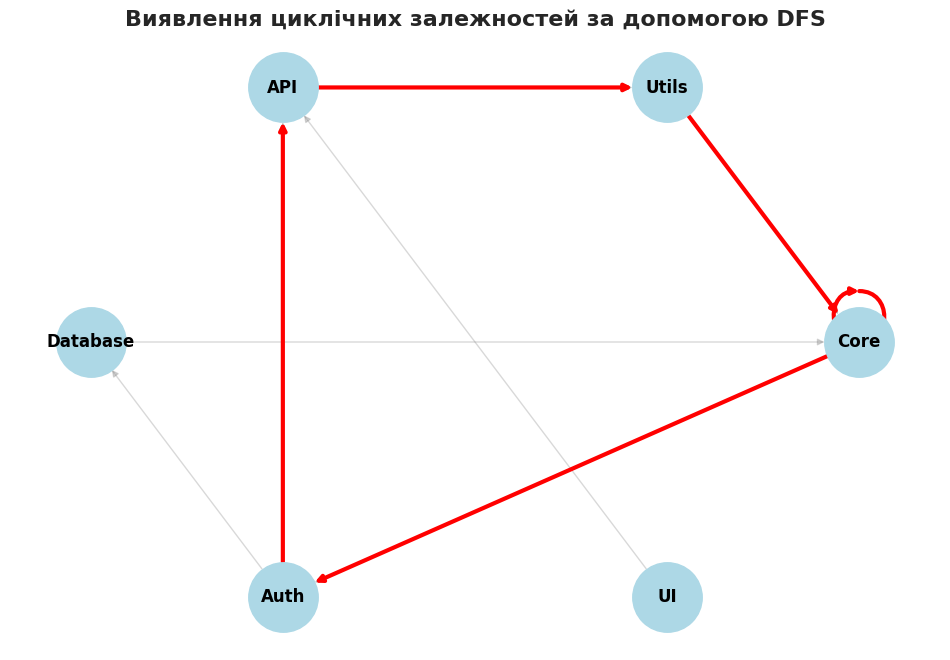

In [17]:
# =============================================================================
# Клітинка 7: Практичний приклад DFS - Виявлення циклічних залежностей
# =============================================================================
dep_graph, tasks = GraphGenerator.create_dependency_graph_with_cycle()

dfs_traversal = DFS(dep_graph)
cycle = dfs_traversal.find_cycle()

fig = TraversalVisualizer.draw_cycle(
    dep_graph,
    cycle=cycle or [],   # <-- лишаємо ID
    labels=tasks,        # {node_id: "Label"}
    title="Виявлення циклічних залежностей за допомогою DFS"
)

if cycle:
    print("🔥 Виявлено цикл:", " → ".join([tasks[n] for n in cycle]))

else:
    print("✅ Циклічних залежностей не виявлено.")
plt.savefig('./data/dependency_cycle.png', dpi=300, bbox_inches='tight')
plt.show()



   ## 1.3 Мінімальне остівне дерево (MST)







   **Задача:** З'єднати всі вершини графу разом за допомогою підмножини ребер, що має мінімальну можливу загальну вагу і не містить циклів.







   **Домени застосування:**



   - **Проектування мереж:** Дизайн мереж комунікацій (інтернет, телефон), електромереж, трубопроводів з мінімальними витратами.



   - **Кластерний аналіз:** Використовується як крок в деяких алгоритмах кластеризації.



   - **Комп'ютерне бачення:** Сегментація зображень.

   ### Алгоритм Краскала (Kruskal) vs Алгоритм Пріма (Prim)







   | Алгоритм | Ідея | Складність | Найкраще для |
   | :--- | :--- | :--- | :--- |
   | **Kruskal**| "Лісовий" підхід: сортує всі ребра і додає найлегші, що не створюють циклів. | `O(E log E)` | Розріджені графи. |
   | **Prim** | "Деревний" підхід: вирощує одне дерево, на кожному кроці додаючи найлегше ребро до нової вершини. | `O(E log V)` | Щільні графи. |

Порівняння алгоритмів MST:
  Algorithm  Total Weight  Num Edges
0   Kruskal     36.508715         14
1      Prim     36.508715         14


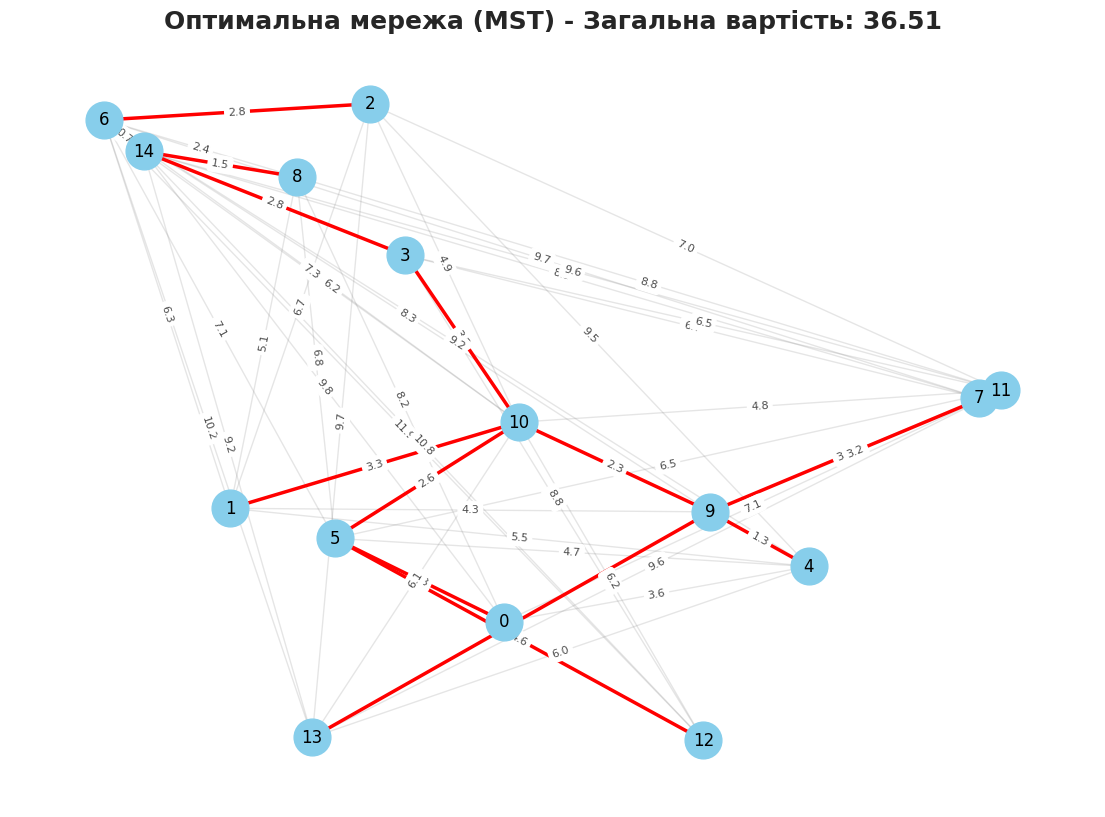

In [18]:
# =============================================================================
# Клітинка 8: Практичний приклад MST - Проектування мережі
# =============================================================================
# Генеруємо граф, що представляє міста та вартість прокладання кабелю
network_graph, pos = GraphGenerator.create_city_road_network(n_intersections=15, connectivity=0.5, seed=50)

# Знаходимо MST за допомогою обох алгоритмів
mst_kruskal = Kruskal.find_mst(network_graph)
mst_prim = Prim.find_mst(network_graph)

print("Порівняння алгоритмів MST:")
mst_comparison_data = {
    'Algorithm': ['Kruskal', 'Prim'],
    'Total Weight': [mst_kruskal['total_weight'], mst_prim['total_weight']],
    'Num Edges': [len(mst_kruskal['edges']), len(mst_prim['edges'])]
}
print(pd.DataFrame(mst_comparison_data))

# Візуалізуємо результат
fig = MstVisualizer.draw_mst(
    network_graph,
    mst_kruskal['edges'],
    title=f"Оптимальна мережа (MST) - Загальна вартість: {mst_kruskal['total_weight']:.2f}",
    pos=pos
)
plt.savefig('./data/mst_network_design.png', dpi=300, bbox_inches='tight')
plt.show()




   ## Завершення Розділу 1







   Ми розглянули ключові класичні алгоритми для роботи з графами. Кожен з них має свою нішу застосування, і розуміння їхніх сильних та слабких сторін є критичним для ефективного вирішення реальних задач.







   **Наступний розділ** буде присвячено структурам даних, які лежать в основі цих та багатьох інших алгоритмів.

  ### Алгоритм Флойда-Воршелла (Floyd-Warshall)



  **Ідея:** Динамічне програмування для знаходження найкоротших шляхів між **усіма парами** вершин. Алгоритм ітеративно розглядає кожну вершину `k` і перевіряє, чи не стане шлях між будь-якими двома вершинами `i` та `j` коротшим, якщо пройти через `k`.



  | Складність | Використання пам'яті | Особливості |
  | :--- | :--- | :--- |
  | `O(V³)` | `O(V²)` | Працює з від'ємними вагами (але не циклами) |



  **Домени застосування:**

  - **Аналіз мереж:** Обчислення "центральності" вузлів.

  - **Біоінформатика:** Порівняння послідовностей білків.

  - **Транспорт:** Створення матриць відстаней між усіма містами в регіоні.

Матриця найкоротших відстаней між усіма пунктами:
          Вокзал  Центр   ТРЦ  Аеропорт  Парк
Вокзал       0.0    5.0   9.0      15.0  11.0
Центр        5.0    0.0   4.0      20.0   6.0
ТРЦ          9.0    4.0   0.0      24.0   2.0
Аеропорт    15.0   20.0  24.0       0.0  26.0
Парк        11.0    6.0   2.0      26.0   0.0

Найбільш центральний вузол (оптимальний для хабу): 'Вокзал' (max dist: 15.0)


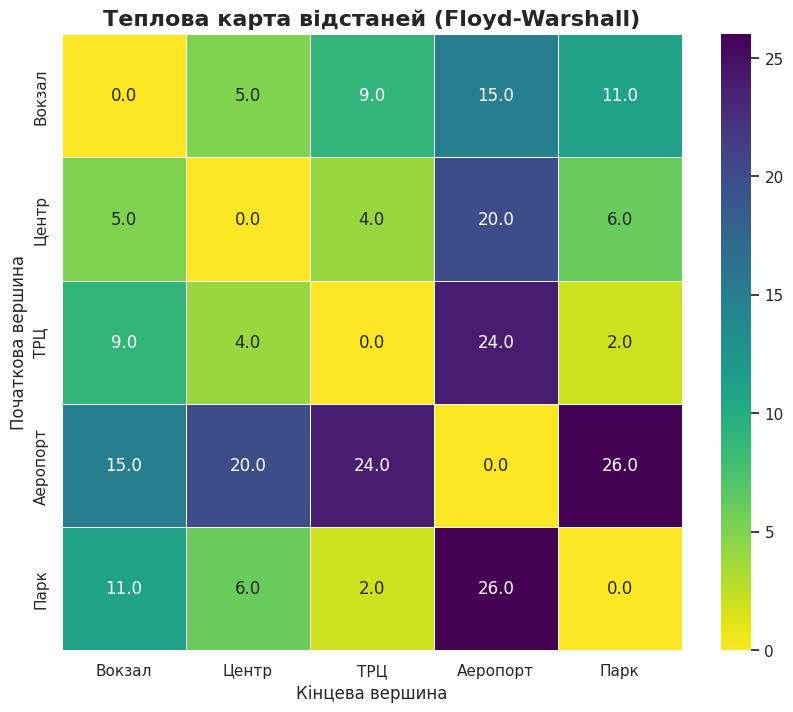

In [19]:
# =============================================================================
# Клітинка 9: Практичний приклад Floyd-Warshall - Матриця відстаней
# =============================================================================
# Створюємо невеликий граф, що імітує ключові транспортні вузли
transit_graph = nx.Graph()
nodes = ["Вокзал", "Аеропорт", "Центр", "ТРЦ", "Парк"]
edges_with_weights = [
    ("Вокзал", "Центр", 5), ("Вокзал", "ТРЦ", 10),
    ("Аеропорт", "Вокзал", 15),
    ("Центр", "Парк", 6), ("Центр", "ТРЦ", 4),
    ("ТРЦ", "Парк", 2)
]
transit_graph.add_weighted_edges_from(edges_with_weights)

# Обчислюємо матрицю відстаней
fw_result = FloydWarshall.find_all_paths(transit_graph)
distance_matrix = fw_result['distances_df']

print("Матриця найкоротших відстаней між усіма пунктами:")
print(distance_matrix)

# Знаходимо "найцентральніший" вузол (з найменшою максимальною відстанню до інших)
centrality = distance_matrix.max(axis=1)
most_central_node = centrality.idxmin()
print(f"\nНайбільш центральний вузол (оптимальний для хабу): '{most_central_node}' (max dist: {centrality.min()})")

# Візуалізуємо матрицю
fig = AnalysisVisualizer.plot_distance_matrix(
    distance_matrix,
    "Теплова карта відстаней (Floyd-Warshall)"
)
plt.savefig('./data/floyd_warshall_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


  ### Двонаправлений пошук (Bidirectional Search)



  **Ідея:** Замість одного пошуку від старту до фінішу, запускаються два одночасно: один від старту (вперед), інший від фінішу (назад). Алгоритм завершується, коли два фронти пошуку зустрічаються.



  **Перевага:** Значно зменшує кількість вузлів для перевірки. Якщо звичайний BFS перевіряє `O(b^d)` вузлів (де `b` - фактор розгалуження, `d` - глибина), то двонаправлений — лише `O(2 * b^(d/2))`.



  **Домени застосування:**

  - **Соціальні мережі:** Швидкий пошук шляху між двома користувачами у величезній мережі.

  - **GPS:** Прискорення пошуку маршруту на великих картах.

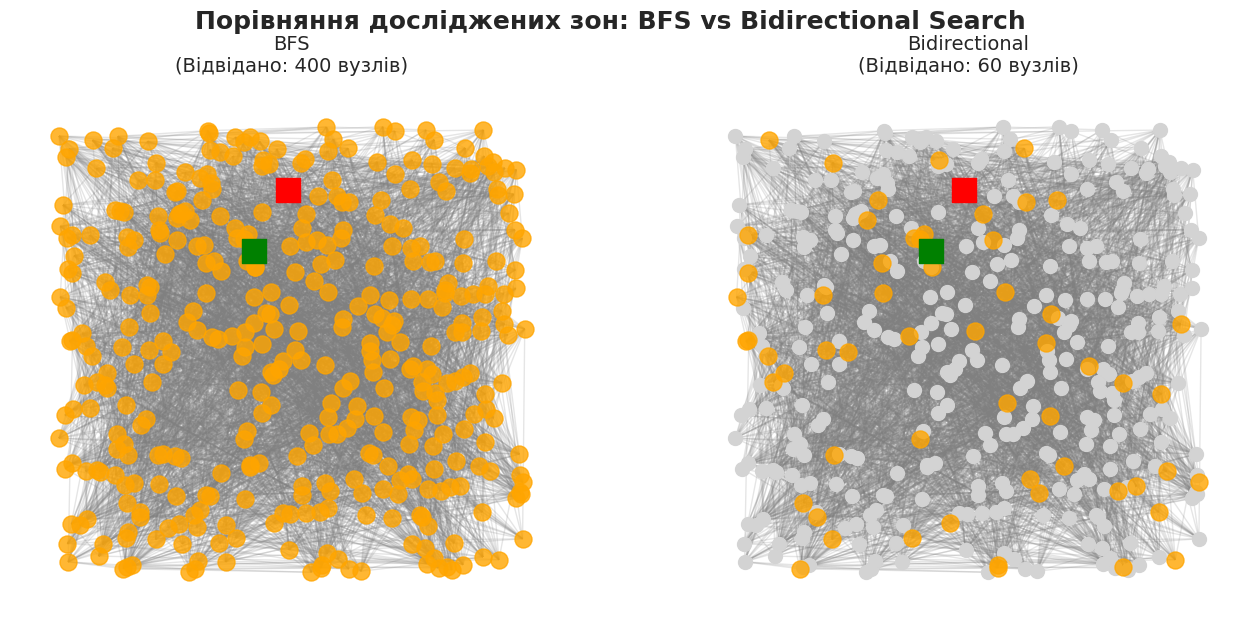

Порівняння продуктивності BFS та Bidirectional Search:
       Algorithm  Visited Nodes  Path Length
0            BFS            400            4
1  Bidirectional             60            4

Прискорення за кількістю відвіданих вузлів: 6.67x


In [20]:
# =============================================================================
# Клітинка 10: Порівняння BFS та Bidirectional Search
# =============================================================================
# Використовуємо великий сітковий граф, де перевага буде очевидною
grid_graph, pos = GraphGenerator.create_city_road_network(n_intersections=400, connectivity=0.05, seed=1)
start_grid, end_grid = 0, 399

# Запускаємо звичайний BFS (використовуємо наш клас з traversal.py)
# Для коректного порівняння, нам потрібна версія BFS, що шукає шлях
def find_path_bfs(graph, start, end):
    res = BFS(graph).traverse(start)
    path = []
    curr = end
    while curr is not None:
        path.append(curr)
        curr = res['parent'].get(curr)
    return {'path': list(reversed(path)), 'visited_nodes': set(res['order'])}

result_bfs = find_path_bfs(grid_graph, start_grid, end_grid)
result_bidir = BidirectionalSearch.find_path(grid_graph, start_grid, end_grid)

# Додаємо ключі для сумісності з візуалізатором
result_bfs['algorithm'] = 'BFS'
result_bidir['algorithm'] = 'Bidirectional'

# Візуалізуємо відвідані вузли
fig = PathVisualizer.draw_visited_nodes_comparison(
    grid_graph, pos,
    results=[result_bfs, result_bidir],
    title="Порівняння досліджених зон: BFS vs Bidirectional Search"
)
plt.savefig('./data/bfs_vs_bidirectional.png', dpi=300, bbox_inches='tight')
plt.show()

# Таблиця результатів
print("Порівняння продуктивності BFS та Bidirectional Search:")
visited_bfs = len(result_bfs['visited_nodes'])
visited_bidir = len(result_bidir['visited_nodes'])
speedup = visited_bfs / visited_bidir if visited_bidir > 0 else float('inf')

summary_df = pd.DataFrame({
    'Algorithm': ['BFS', 'Bidirectional'],
    'Visited Nodes': [visited_bfs, visited_bidir],
    'Path Length': [len(result_bfs['path']), len(result_bidir['path'])]
})
print(summary_df)
print(f"\nПрискорення за кількістю відвіданих вузлів: {speedup:.2f}x")


  ### Просунуті алгоритми (Концептуальний огляд)



  **Contraction Hierarchies (CH)** та **ALT** — це алгоритми, що вимагають значного етапу **попередньої обробки (препроцесингу)** графу.



  - **Ідея CH:** "Стиснути" граф, створюючи ярлики (shortcuts) через менш важливі вузли. Наприклад, на магістралі Київ-Одеса всі проміжні села "стискаються" в один швидкий шлях.

  - **Ідея ALT:** Використовує "орієнтири" (landmarks) та нерівність трикутника для отримання дуже точної евристики для A*.



  Ці методи дозволяють знаходити шляхи на континентальних графах за мілісекунди, що є основою сучасних навігаційних систем. Їх реалізація складна, але розуміння принципу є ключовим.

  ## Розділ 3: Структури даних

  ### 3.1 Графові структури



  Спосіб, у який ми зберігаємо граф у пам'яті, напряму впливає на ефективність алгоритмів. Вибір правильної структури — це перший крок до оптимізації.

  | Структура | Перевірка ребра | Ітерація сусідів | Пам'ять | Найкраще для |
  | :--- | :--- | :--- | :--- | :--- |
  | **Матриця суміжності** | `O(1)` | `O(V)` | `O(V²)` | **Щільні графи** |
  | **Список суміжності** | `O(deg(v))` | `O(deg(v))` | `O(V+E)`| **Розріджені графи** |

In [25]:
!pip install jinja2

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)


In [ ]:
# =============================================================================
# Клітинка 11: Бенчмарк представлень графу (покращена таблиця)
# =============================================================================


def benchmark_representations(n_nodes, density):
    g = nx.fast_gnp_random_graph(n_nodes, density, seed=42)
    
    # 1. Матриця суміжності
    adj_matrix = nx.to_numpy_array(g)
    mem_matrix = adj_matrix.nbytes / 1024  # KB

    # 2. Список суміжності (приблизна оцінка)
    mem_list = (g.number_of_nodes() * 8 + g.number_of_edges() * 2 * 16) / 1024

    # 3. Операції
    nodes_to_check = np.random.randint(0, n_nodes, size=(1000, 2))
    
    start = time.perf_counter()
    for u, v in nodes_to_check:
        _ = adj_matrix[u, v] > 0
    time_matrix_check = (time.perf_counter() - start) * 1e6  # μs

    start = time.perf_counter()
    for u, v in nodes_to_check:
        _ = g.has_edge(u, v)
    time_list_check = (time.perf_counter() - start) * 1e6  # μs
    
    return {
        'Graph Density': f"{density:.0%}",
        'Adjacency Matrix\nMemory (KB)': mem_matrix,
        'Adjacency List\nMemory (KB)': mem_list,
        'Edge Check\n(Matrix, μs)': time_matrix_check,
        'Edge Check\n(List, μs)': time_list_check
    }


# Тестуємо на розрідженому та щільному графах
n = 500
sparse_results = benchmark_representations(n, 0.01)  # 1%
dense_results  = benchmark_representations(n, 0.50)  # 50%

benchmark_df = pd.DataFrame([sparse_results, dense_results]).round(2)


def highlight_min(s):
    """Підсвічує мінімальне значення у стовпці."""
    is_min = s == s.min()
    return ['background-color: #d4edda; font-weight: 600;' if v else '' for v in is_min]

styled_df = (
    benchmark_df.style
    .set_caption(f"📊 Benchmark: Adjacency Matrix vs List (N={n})")
    .set_table_styles([
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'left')]},
        {'selector': 'th', 'props': [('background-color', "#2b5f93"), ('font-size', '13px'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '13px'), ('text-align', 'center')]}
    ])
    .apply(highlight_min, subset=['Adjacency Matrix\nMemory (KB)', 'Adjacency List\nMemory (KB)'])
    .apply(highlight_min, subset=['Edge Check\n(Matrix, μs)', 'Edge Check\n(List, μs)'])
    .format({
        'Adjacency Matrix\nMemory (KB)': '{:,.1f}',
        'Adjacency List\nMemory (KB)': '{:,.1f}',
        'Edge Check\n(Matrix, μs)': '{:,.2f}',
        'Edge Check\n(List, μs)': '{:,.2f}',
    })
)

styled_df


,Graph Density,Adjacency Matrix Memory (KB),Adjacency List Memory (KB),"Edge Check (Matrix, μs)","Edge Check (List, μs)"
0,1%,"1,953.1",42.2,"1,094.85","1,072.15"
1,50%,"1,953.1","1,951.6","1,326.03","1,385.97"


  #### Висновки

  - **Пам'ять:** Для **розріджених** графів (типових для реального світу, як-от дорожні мережі) список суміжності є значно ефективнішим. Для **щільних** графів різниця в пам'яті менша.

  - **Швидкість:** Перевірка наявності ребра в матриці **завжди** швидша (`O(1)`), що робить її ідеальною для алгоритмів, де ця операція є домінуючою.



  **Головне правило:** Використовуйте **список суміжності** за замовчуванням, якщо не впевнені. Це золота середина для більшості задач.